1.. Find the census trck shape files online (American Fact Finder has them), http://www1.nyc.gov/ has them. The folder you should download is names nycb2010_16d. 
Load it as a geopandas file

In [1]:
import os as os
import zipfile
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import shapely
from __future__ import print_function
import pylab as pl
import matplotlib.patches as mpatches
%pylab inline
PUIDATA=os.getenv('PUIDATA')

Populating the interactive namespace from numpy and matplotlib


In [2]:
##Get Census tract shape file, move to PUIDATA folder, and read it using Geopandas into a dataframe. 
!curl -O "http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip"
os.rename("nycb2010_16d.zip", "nyc_census_shape_file.zip")
shapefile="nyc_census_shape_file.zip"
os.system("mv " + shapefile + " " + os.getenv("PUIDATA"))
zf = zipfile.ZipFile(PUIDATA + "/" + shapefile, mode='r')
zf.extractall(PUIDATA + "/" +  "nyc_census_shape_file/")
zf.close()
shapefile = PUIDATA +"/nyc_census_shape_file/nycb2010_16d"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5616k  100 5616k    0     0  50.7M      0 --:--:-- --:--:-- --:--:-- 53.7M


In [3]:
shape_path = shapefile
ct_shape = GeoDataFrame.from_file(shape_path)

In [4]:
# a view of the shape file loaded as a geojson file will look like this. Notice the coordinates. They are in 
# epsg=2263 is US feet. You want to convert them in epsg=4326: lat/lon . 
# Look at the notebook https://github.com/fedhere/PUI2016_fb55/blob/master/Lab9_SRK325/GeospatialAnalysis_CitiBike.ipynb
ct_shape.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,..."
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,"POLYGON ((963363.1168212891 167356.3336181641,..."
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936035156,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.891784668 158246.7521972656, ..."


In [5]:
ct_shape.columns

Index([ u'BCTCB2010',   u'BoroCode',   u'BoroName',     u'CB2010',
           u'CT2010', u'Shape_Area', u'Shape_Leng',   u'geometry'],
      dtype='object')

In [6]:
ct_shape.crs = from_epsg(2263) # epsg=4326: lat/on | epsg=2263 is US feet
ct_latlon=ct_shape.to_crs(epsg=4326)# from ft2 to mi2 

In [7]:
ct_latlon.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374566...
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438018 40.61085506705415...
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452711...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123923...
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...


2.. Extract only the Brooklyn shape polygons and convert the coordinates to lat/lon 

In [8]:
bk_ct = ct_latlon[(ct_latlon["BoroCode"] == '3')]
bk_ct.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


In [9]:
print('Number of Brooklyn census tracts: ', len(bk_ct))

Number of Brooklyn census tracts:  9682


3.. Find the coordinates of CUSP: 1 MetroTech Brooklyn. Create a Point shapely geometry with the coordinates of CUSP

    shapely.geometry.Point()

In [10]:
#According to Google, Lat/Lon CUSP coords: 40.6931299,-73.9888252
CUSP = shapely.geometry.Point(-73.9888252, 40.6931299)

4.. Loop over the Brookly polygons (nearly 10000) and assess find in which geometry the polygon is contained

In [11]:
for i in bk_ct.index:
    if shapely.geometry.asShape(bk_ct.geometry.loc[i]).contains(CUSP):
        cusp_ct = bk_ct.BCTCB2010[i]
        print ("CUSP is located in census tract %s" %cusp_ct)
        print (bk_ct.geometry[i])

CUSP is located in census tract 30011001002
POLYGON ((-73.98716132813911 40.69496169586319, -73.98720083280509 40.6942679880677, -73.98722751058246 40.69379951950234, -73.98725396415627 40.6931249027317, -73.98729894947923 40.69223407539822, -73.98818594276516 40.69227701684913, -73.98875073043592 40.69229640711011, -73.98889162251962 40.6923012470929, -73.98897455556948 40.69230552383393, -73.98897091388419 40.69243721409796, -73.98897206315063 40.69249619876403, -73.98895154976945 40.69284970172215, -73.98888135194944 40.69434605001802, -73.98887818530989 40.69441356156402, -73.98886115711706 40.69472847985681, -73.98884531151906 40.69502153056919, -73.98875574890583 40.69501835106358, -73.98861349022471 40.69501329500623, -73.98716132813911 40.69496169586319))


5.. Plot one every 10 polygons of brooklyn (using the geopandas datafame method plot)
and overplot the locati`on of cusp as a point (using pylab.scatter)
Overplot also the census track that contains cusp in red (using the geopandas datafame method plot)

In [12]:
bk_ct_slim = bk_ct[::10]
print ('BK census tracts divided by 10: ', len(bk_ct)/10)
print ('Results: ', len(bk_ct_slim))

BK census tracts divided by 10:  968
Results:  969


NameError: name 'radar_circle' is not defined

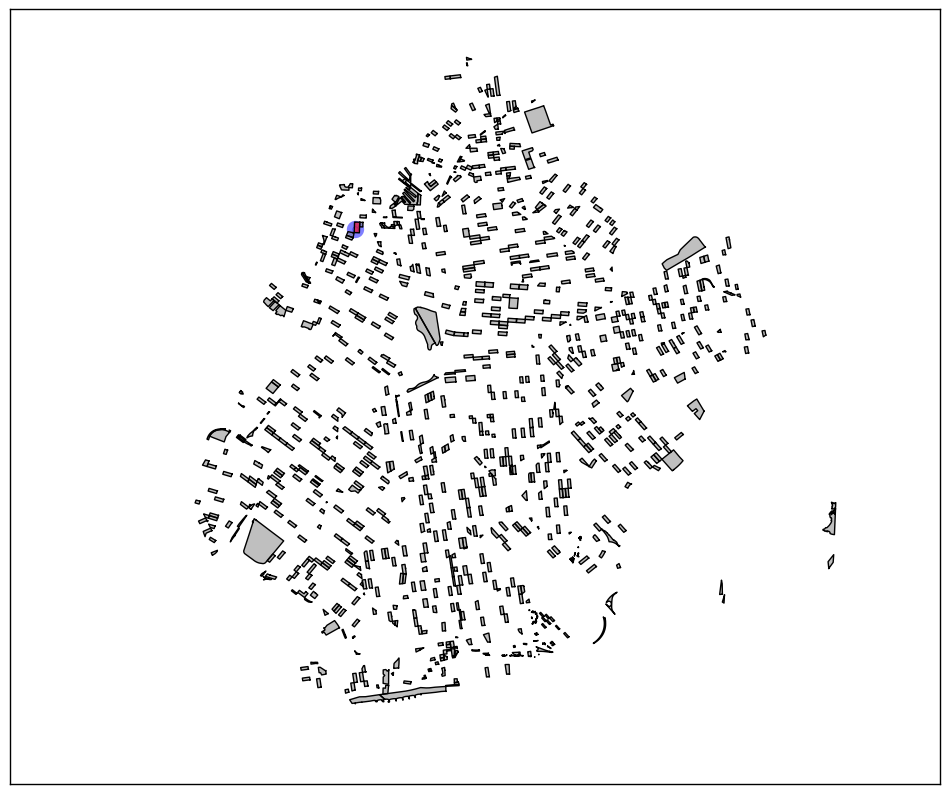

In [13]:
f, ax = plt.subplots(figsize=(12, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bk_ct_slim.plot(ax=ax, color='grey')
bk_ct[(bk_ct.BCTCB2010 == cusp_ct)].plot(alpha=.6, ax=ax, color='red')
pl.scatter(CUSP.x, CUSP.y, color='blue', edgecolors='blue', linewidths=8, alpha=.5)
plt.legend(handles=[radar_circle])

ax.set_title("CUSP Location and an Assortment of 1/10 of Brooklyn's Census Tracts", fontsize='large')
pl.figtext(0.1, -0.00000000001, '''The figure above depicts a random assortment of 1/10 of Brooklyn's census tracts. 
CUSP is displayed as a red point located in tract %s. ''' %cusp_ct, 
           fontsize='small')